In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression


In [2]:
df_dataset = pd.read_csv("./input.csv", comment="#")
df_dataset.head()

,Set,Sequence,Spacing,Fluorescence.Average,Fluorescence.Stdev,Fluorescence.NumMeasurements,Paper.Salis2009.Total.dG,OSTIR.ViennaRNA.Turner2004.No.Spacing.dG
0,1.0,TTCTAGAAAAAAAATAAGGAGGTATGGCGAGCTCTGAAGACGTTAT...,0,101.28,54.34,5,4.104,-8.975
1,1.0,TTCTAGAAAAAAAATAAGGAGGTAATGGCGAGCTCTGAAGACGTTA...,1,133.59,118.37,5,3.881,-8.975
2,1.0,TTCTAGAAAAAAAATAAGGAGGTAAATGGCGAGCTCTGAAGACGTT...,2,247.70,119.81,5,1.554,-8.975
3,1.0,TTCTAGAAAAAAAATAAGGAGGTAAAATGGCGAGCTCTGAAGACGT...,3,24972.09,4944.50,5,-6.550,-8.975
4,1.0,TTCTAGAAAAAAAATAAGGAGGTAAAAATGGCGAGCTCTGAAGACG...,4,53933.01,15012.58,5,-8.070,-8.975


In [3]:
dG_no_spacing = df_dataset["OSTIR.ViennaRNA.Turner2004.No.Spacing.dG"].values

# onehot encoding - same factor in R
spacing = df_dataset["Spacing"].astype(float).values
onehot_df = pd.get_dummies(df_dataset["Spacing"], dtype=float)
spacing_onehot, spacing_label = onehot_df.values, onehot_df.columns

X = np.concatenate([dG_no_spacing.reshape(-1, 1), spacing_onehot], axis=1)
X_label = ["dG"] + [f"spacing_{i}" for i in spacing_label]
y = np.log(df_dataset["Fluorescence.Average"].values)

In [4]:
spacing_optimal = 5
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

Beta = -model.coef_[X_label.index("dG")]
logK = model.coef_[X_label.index(f"spacing_{spacing_optimal}")]

spacing_deviation_dG = -(1 / Beta) * (y - logK) - dG_no_spacing

In [5]:
def assign_parameters(params):
    # assign to corresponding variables
    c_stretched = np.array(params[0:3])
    c_compressed = np.array(params[3:7])
    y0 = params[7]
    
    # override some parameters
    # define additional constraints here
    c_stretched[2] = 0
    # c_compressed[2] = 2
    c_compressed[3] = 3
    
    return c_stretched, c_compressed, y0


def spring_model(spacing, *params, use_y0=True):
    # assign to variables
    c_stretched, c_compressed, y0 = assign_parameters(params)
    
    # calculate stretched and compressed values
    spacing_diff = spacing - spacing_optimal
    stretched = c_stretched[0] * spacing_diff ** 2 + c_stretched[1] * spacing_diff + c_stretched[2]
    compressed = c_compressed[0] / (1.0 + np.exp(c_compressed[1] * (spacing_diff + c_compressed[2]))) ** c_compressed[3]
    
    # save and output
    output = np.zeros_like(spacing)
    output[spacing_diff >= 0] = stretched[spacing_diff >= 0]
    output[spacing_diff < 0] = compressed[spacing_diff < 0]
    if use_y0: output += y0
    return output


In [6]:
# fit parameters
param_fit, cov = curve_fit(
    spring_model,
    spacing,
    spacing_deviation_dG,
    p0=[0.048, 0.24, 0.0, 12.2, 2.5, 2.0, 3.0, 0.0]
)

c_stretched, c_compressed, y0 = assign_parameters(param_fit)
logK += y0 * -Beta

/var/folders/_3/fn7zmzc10j3g4t9s9004ffyc0000gn/T/ipykernel_94515/132433045.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  param_fit, cov = curve_fit(


In [7]:
spacing_penalty_dG = spring_model(spacing, *param_fit, use_y0=False)
total_dG = dG_no_spacing + spacing_penalty_dG
log_expression = (-Beta * total_dG + logK)


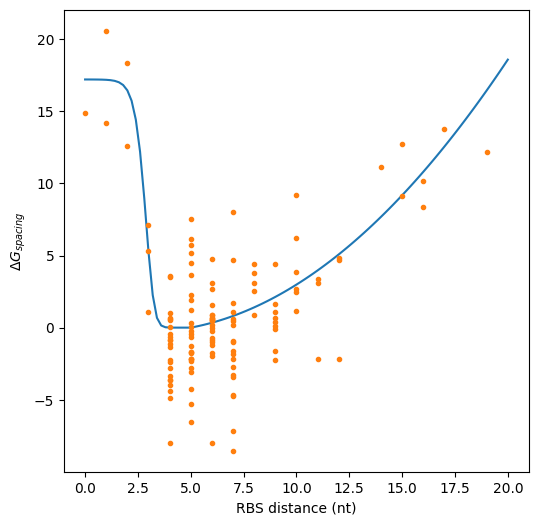

In [8]:
# plot fitting result
x_plot = np.linspace(0, 20, 101)
plt.figure(figsize=(6, 6))
plt.plot(x_plot, spring_model(x_plot, *param_fit, use_y0=False))
plt.plot(spacing, spacing_deviation_dG, '.')
plt.xlabel('RBS distance (nt)')
plt.ylabel('$\Delta G_{spacing}$')
plt.show()

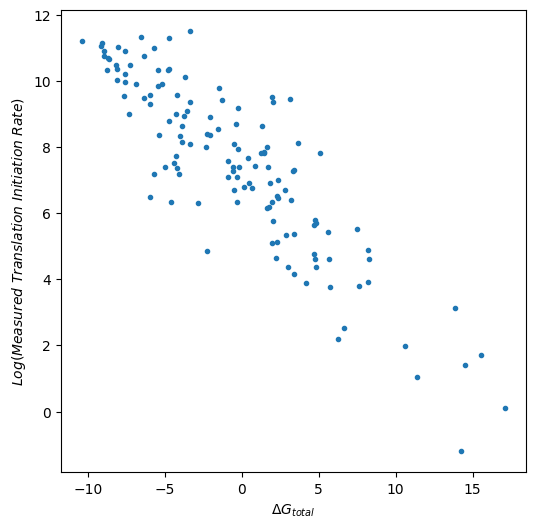

In [9]:
# plot predicted vs measured log10 expression
plt.figure(figsize=(6, 6))
plt.plot(total_dG, y, ".")

plt.xlabel("$\Delta G_{total}$")
plt.ylabel("$Log(Measured\ Translation\ Initiation\ Rate)$")
plt.show()

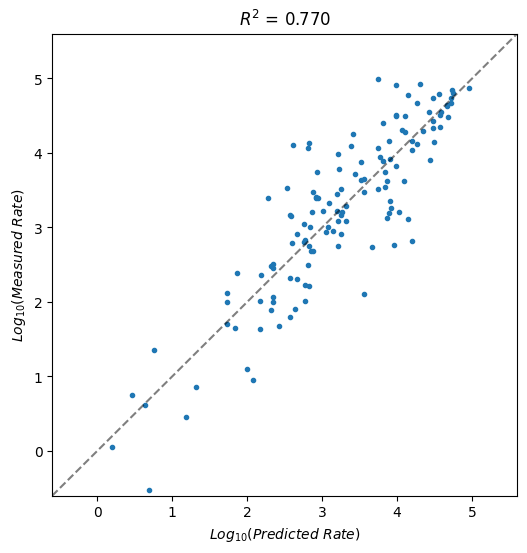

In [10]:
# plot predicted vs measured log10 expression
plt.figure(figsize=(6, 6))
plt.plot(log_expression / np.log(10), y / np.log(10), '.')

plt.title(f"$R^2$ = {np.corrcoef(log_expression, y)[0, 1] ** 2:.3f}")
lim = (-0.6, 5.6)
plt.plot(lim, lim, 'k--', alpha=0.5)
plt.xlim(lim)
plt.ylim(lim)
plt.xlabel('$Log_{10}(Predicted\ Rate)$')
plt.ylabel('$Log_{10}(Measured\ Rate)$')
plt.show()


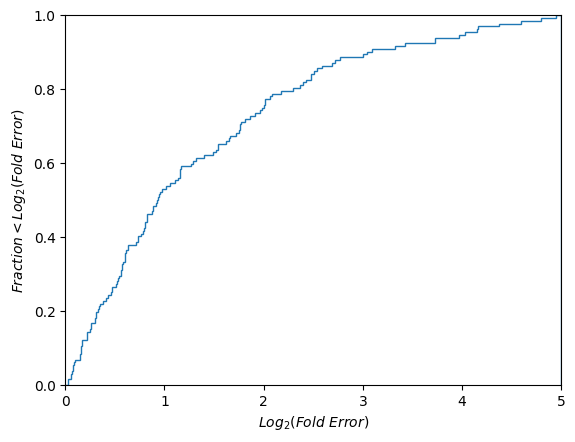

In [11]:
# plot cumulative log2 fold error
log2_tir_ratio = (y - log_expression) / np.log(2)

plt.figure()
plt.hist(
    np.abs(log2_tir_ratio),
    bins=np.linspace(0, 5, 501),
    histtype='step',
    cumulative=True,
    density=True,
    fill=False,
)
plt.xlabel("$Log_2(Fold\ Error)$")
plt.ylabel("$Fraction < Log_2(Fold\ Error)$")
plt.xlim((0, 5))
plt.ylim((0, 1))
plt.show()

In [12]:
# export constants to a json file
from ostir.ostir_calculations import OstirConstants
calibrated_constants = OstirConstants(
    Beta=Beta,
    logK=logK,
    dG_spacing_constant_push=c_compressed,
    dG_spacing_constant_pull=c_stretched
)

calibrated_constants.save_to_json('./fitted_constants.json')


/Users/ethanwong/miniconda3/envs/ostir/lib/python3.11/site-packages/ostir/ViennaRNA.py:24: UserWarning: RBS Calculator Vienna is missing dependency ViennaRNA!
  warnings.warn('RBS Calculator Vienna is missing dependency ViennaRNA!')


In [13]:
df_dataset['dG'] = dG_no_spacing
df_dataset['Fluorescence.Log.Average'] = y
df_dataset['spacing.deviation.dG'] = spacing_deviation_dG
df_dataset['spacing.penalty.dG'] = spacing_penalty_dG
df_dataset['total.dG'] = total_dG
df_dataset['Log.Predicted.Translation.Initiation.Rate'] = log_expression
df_dataset['Log10.Predicted.Translation.Initiation.Rate'] = log_expression / np.log(10)
df_dataset['Log.Measured.Translation.Initiation.Rate'] = y
df_dataset['Log10.Measured.Translation.Initiation.Rate'] = y / np.log(10)
df_dataset['Log2.Translation.Initiation.Rate.Ratio'] = log2_tir_ratio
df_dataset['Abs.Log2.Translation.Initiation.Rate.Ratio'] = np.abs(log2_tir_ratio)
df_dataset['Predicted.Translation.Initiation.Rate'] = np.exp(log_expression)
df_dataset.to_csv('output_fit_values_python.csv')

In [14]:
# example of deploying the calibrated constants
from ostir import ostir_calculations, run_ostir

ostir_calculations.ostir_constants = calibrated_constants
# alternatively, load from file:
# ostir_calculations.ostir_constants = ostir_calculations.OstirConstants.load_from_json('./fitted_constants.json')
seq = "TTCTAGAAAAAAAATAAGGAGGTATGGCGAGCTCTGAAGACGTTATCAAAGAGTTCATGCGTTTCAAAGTTCGTATGGAA"

results = run_ostir(seq)
print(
    *[
        f'start position {result["start_position"]}, expression {result["expression"]}'
        for result in results
    ],
    sep="\n",
)

start position 24, expression 53.819
start position 57, expression 0.0558
start position 75, expression 227.5888
